In [1]:
%matplotlib inline
import numpy as np
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import matplotlib
from astropy.convolution import convolve, Gaussian2DKernel
from scipy.optimize import fsolve, fmin
from astropy.io import fits
import scipy.interpolate as interp
import emcee
import corner
from multiprocess import Pool
import multiprocessing as mp
mp.cpu_count()

10

In [2]:
# filename = "tutorial_25w_1500it.h5" #"tutorial_10w_1500it.h5"
filename = "MCMC_outputs/trimmed_20w_3000it.h5" #"tutorial_10w_1500it.h5"
# nwalkers = 10
# niter = 500
# initial = np.array([603, 0.3, 0.17])
ndims = 6 #6 #len(initial)
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain()
# print(samples[0,:,:])

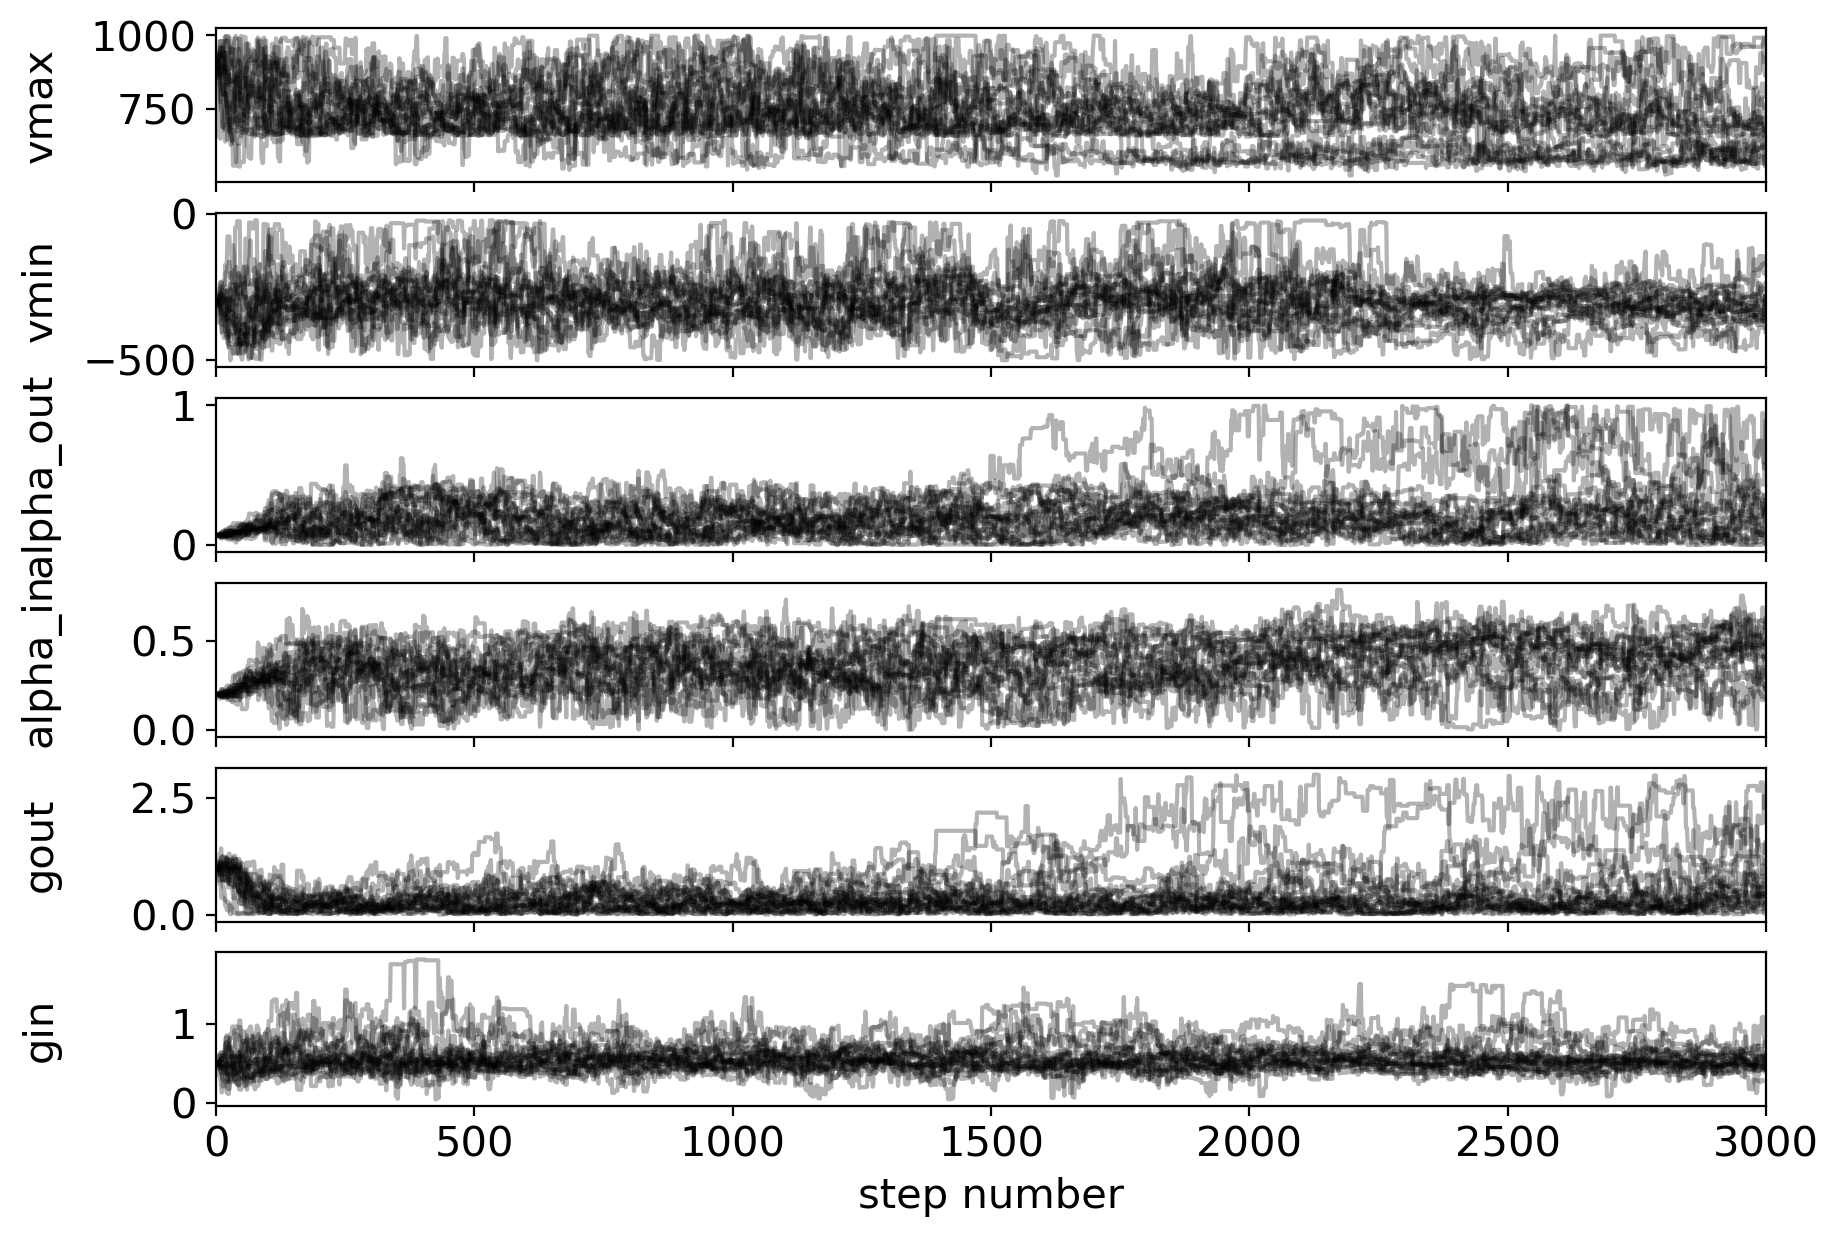

In [3]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
labels = ["vmax", "vmin", "alpha_out", "alpha_in", "gout", "gin"]
# labels = ["vmin", "alpha_in", "gin"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [4]:
tau = reader.get_autocorr_time(quiet=True)
print(tau)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
# samples = reader.get_chain(flat=True)

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [196.31959559 101.51408374 165.04156633 154.72300457 167.20693955
 101.14871667]


[196.31959559 101.51408374 165.04156633 154.72300457 167.20693955
 101.14871667]


627.6630385715686
624.9792050855008
635.2947798456498


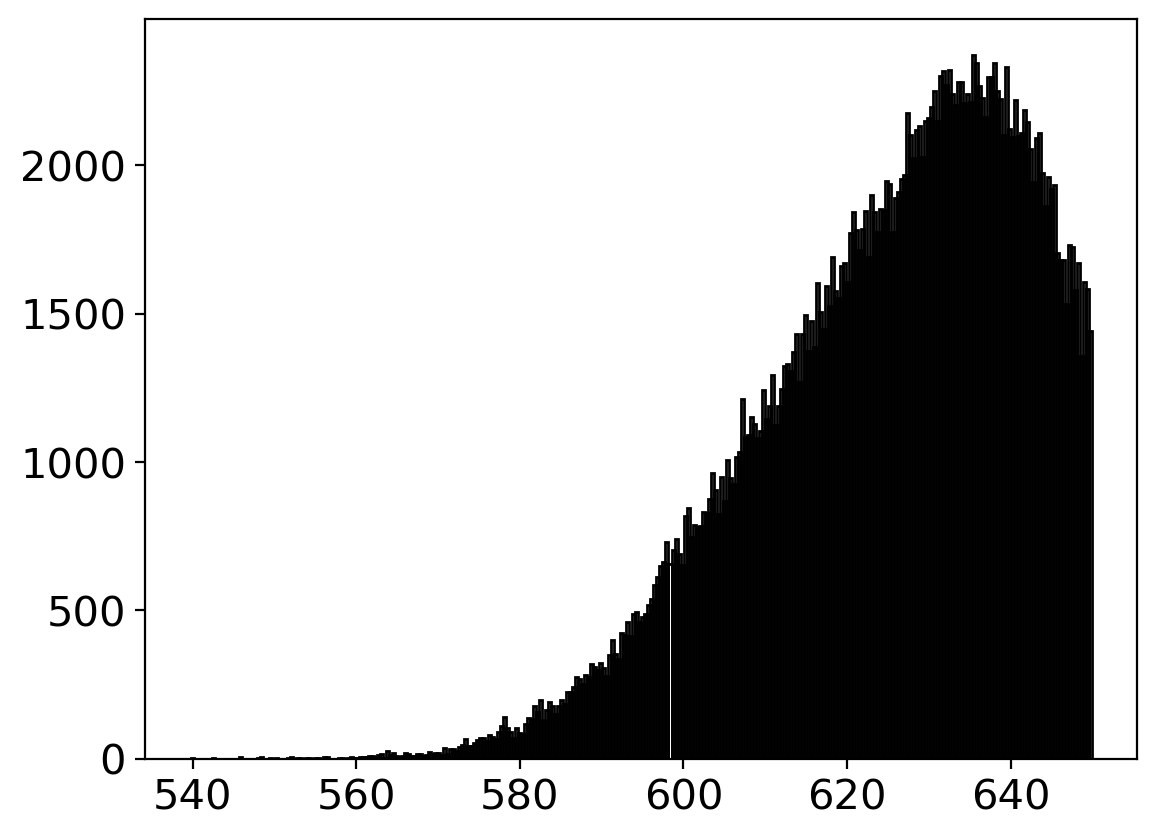

In [30]:
flat_samples = reader.get_chain(flat=True) # discard=100, thin=15, flat=True
print(np.median(flat_samples[:,0]))
print(np.mean(flat_samples[:,0]))

hi = plt.hist(flat_samples[:,0], fill=None, bins=300)
print(hi[1][np.argmax(hi[0])])
plt.show()


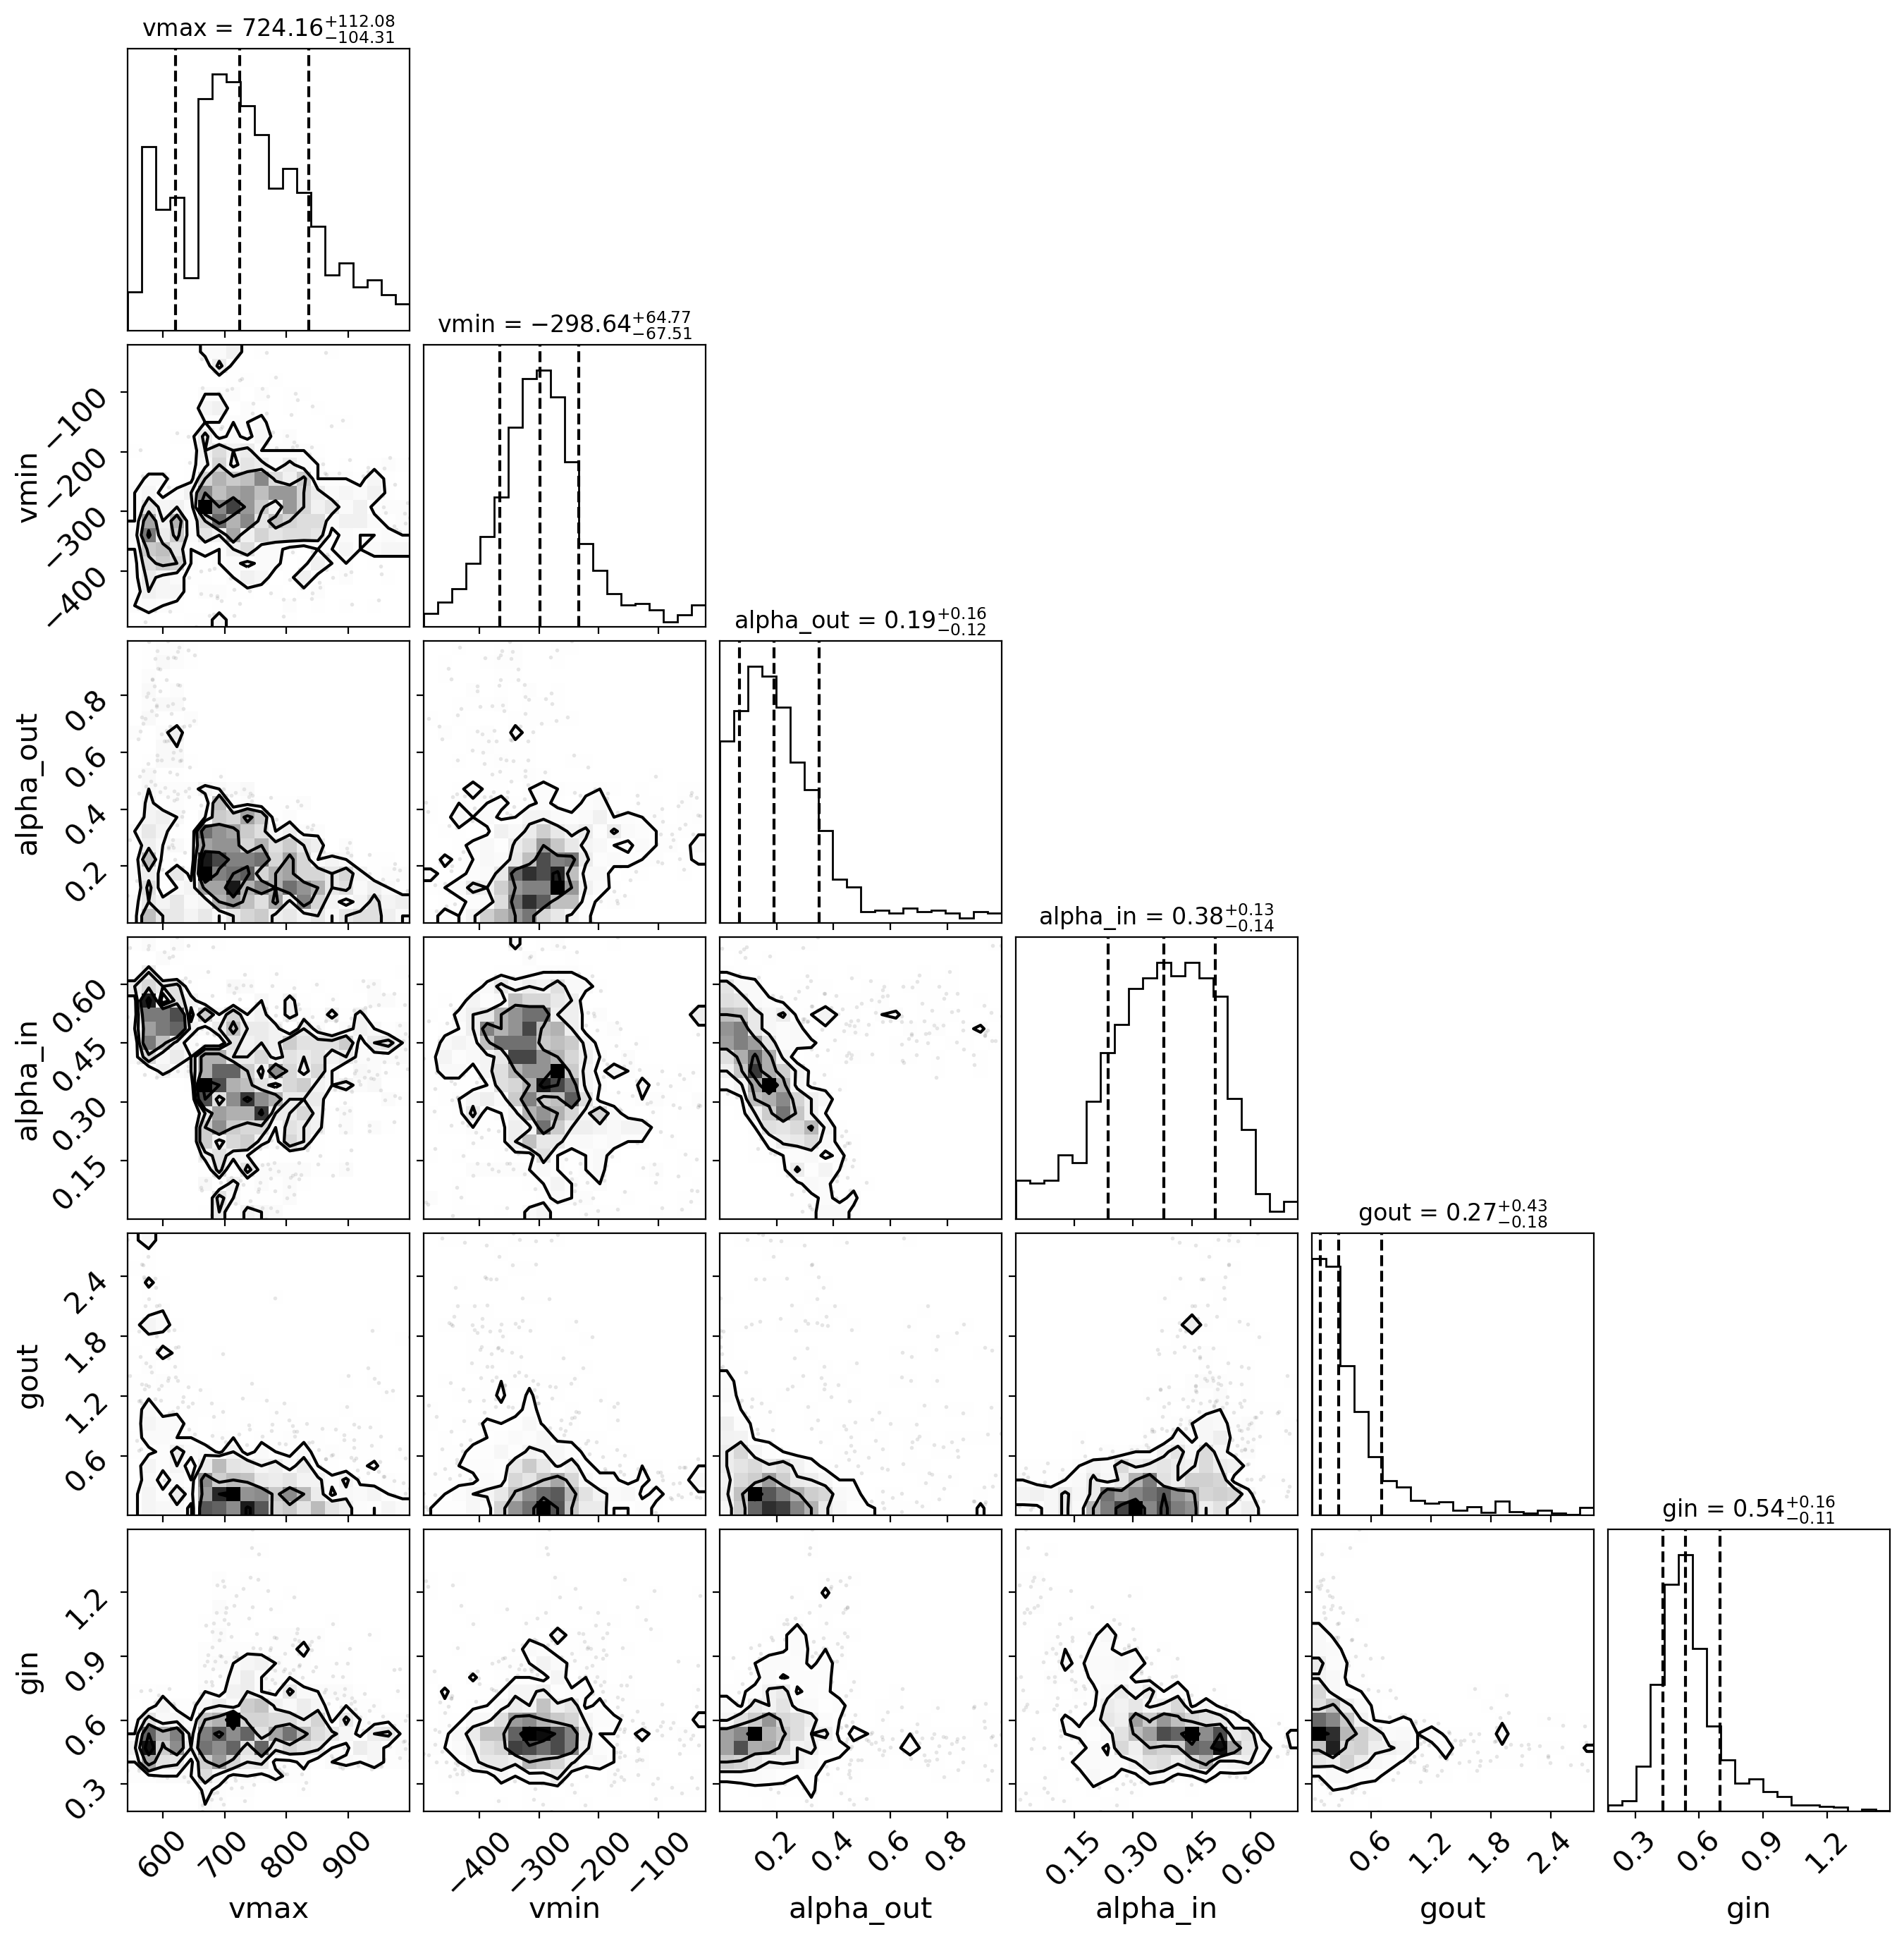

In [5]:
fig = corner.corner(
    samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, #truths=initial
);

In [44]:
# filename = "tutorial_25w_1500it.h5" #"tutorial_10w_1500it.h5"
filename = "tutorial2.h5" #"tutorial_10w_1500it.h5"
# nwalkers = 10
# niter = 500
# initial = np.array([603, 0.3, 0.17])
ndims = 3 #6 #len(initial)
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain(flat=True)
# print(samples[0,:,:])

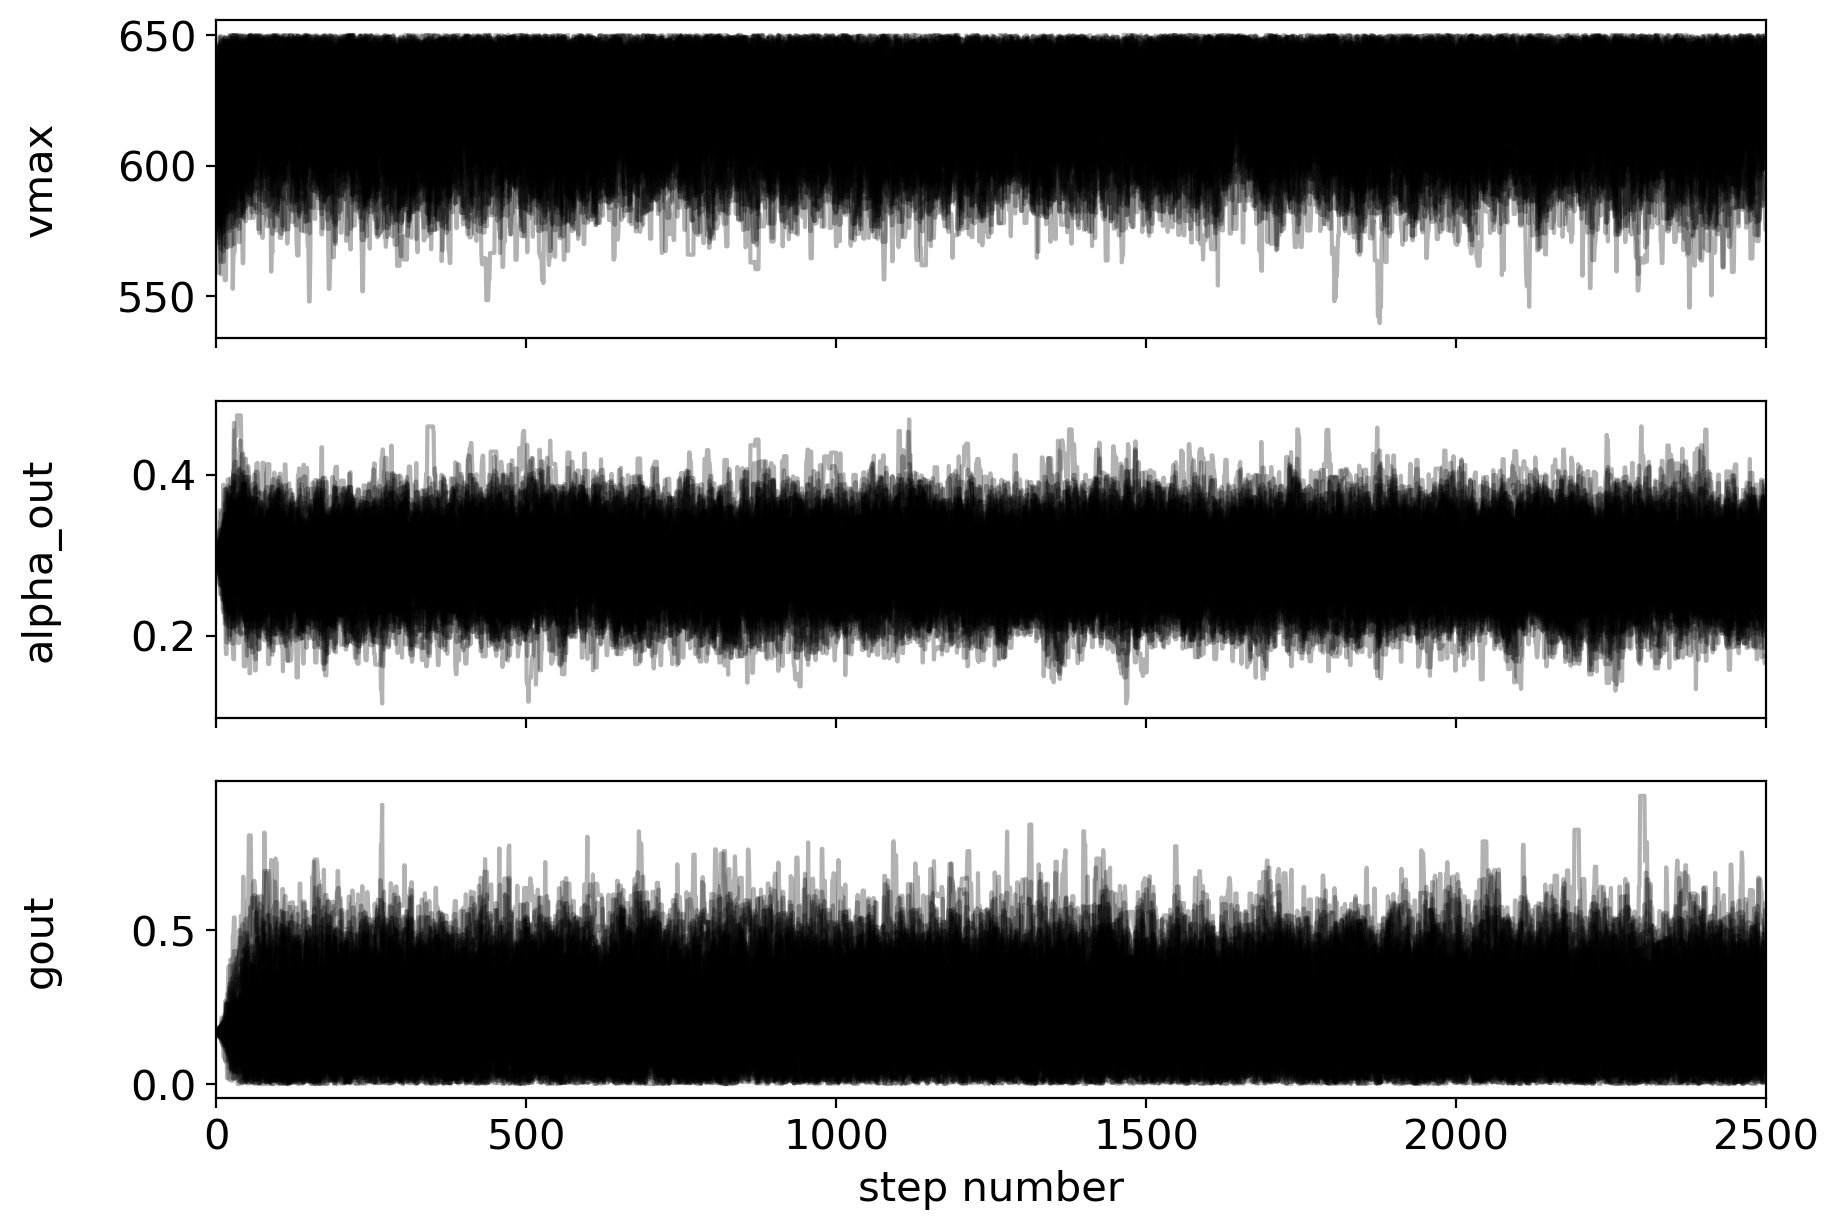

In [42]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
# samples = sampler.get_chain()
# labels = ["vmax", "vmin", "alpha_out", "alpha_in", "gout", "gin"]
labels = ["vmax", "alpha_out", "gout"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

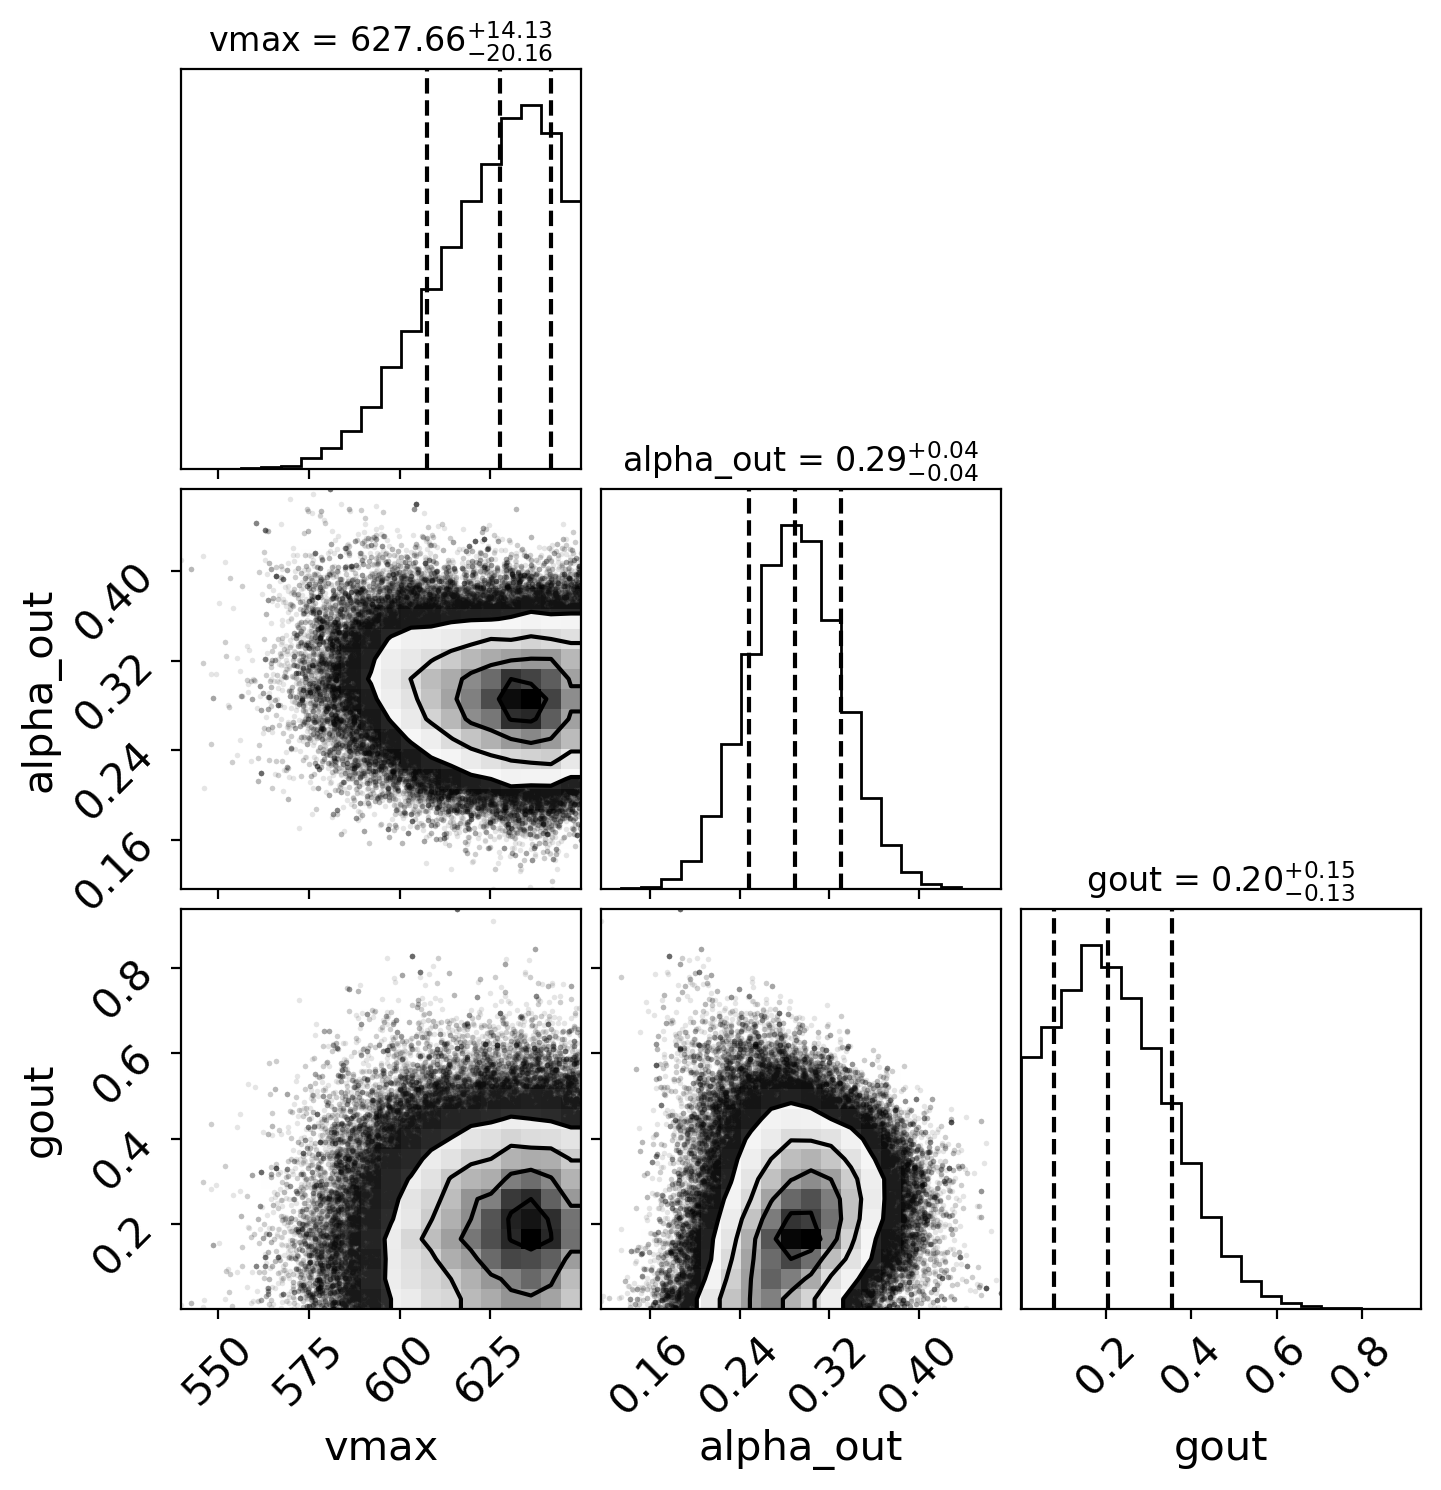

In [45]:
fig = corner.corner(
    samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, #truths=initial
);

In [12]:
thtest = (603, 0.3, 0.17)
lnlike(thtest)

/tmp/ipykernel_2869270/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2869270/3364415001.py:106: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)
/tmp/ipykernel_2869270/3364415001.py:131: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far)


-7.174882546368743

/tmp/ipykernel_2869270/3364415001.py:15: RuntimeWarning: invalid value encountered in sqrt
  vout = np.sqrt(vi**2 + A*(-np.log((Rs+1)/Rs) + (1/r * np.log((Rs+r)/Rs))))
/tmp/ipykernel_2869270/3364415001.py:106: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_out_near) + np.nanmean(tau_out_far)
/tmp/ipykernel_2869270/3364415001.py:131: RuntimeWarning: Mean of empty slice
  tau_tot = np.nanmean(tau_in_near) + np.nanmean(tau_in_far)


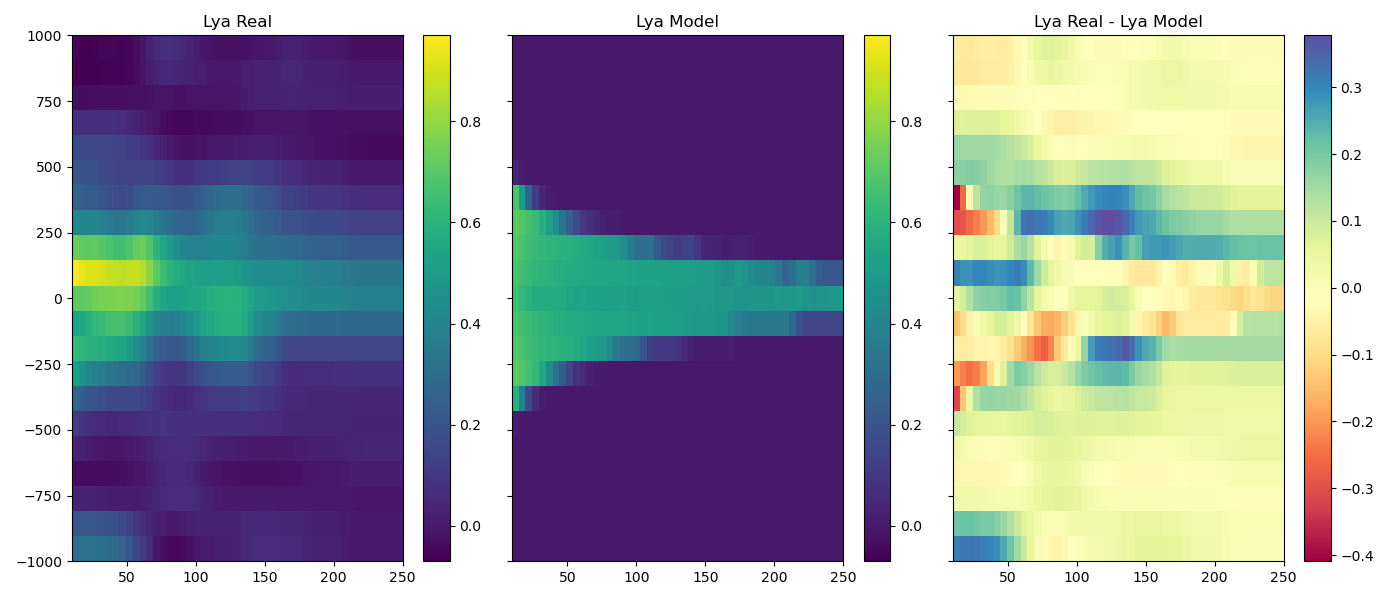

In [11]:
thtest = (603, 0.3, 0.17) #vout, vin, aout, ain, gout, gin
lya_model = model(thtest) 

vmi, vma = -0.07, 0.97

fig, ax = plt.subplots(1,3, figsize = (14,6), sharex=True, sharey=True)
re = ax[0].imshow(lya_real, aspect='auto', origin='lower', 
                  extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(re, ax=ax[0])
ax[0].set_title('Lya Real')

mod = ax[1].imshow(lya_model, aspect='auto', origin='lower', 
                   extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], vmin = vmi, vmax = vma)
fig.colorbar(mod, ax=ax[1])
ax[1].set_title('Lya Model')

diff = ax[2].imshow(lya_real - lya_model, aspect='auto', origin='lower',
                    extent = [bvec_final.min(), bvec_final.max(), vvec_final.min(), vvec_final.max()], cmap='Spectral')
fig.colorbar(diff, ax=ax[2])
ax[2].set_title('Lya Real - Lya Model')
fig.tight_layout()
plt.show()